In [1]:
import torch
import io
import os
import torch.optim as optim
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pix2pix.Discriminator import Discriminator
from pix2pix.Generator import Generator
from pix2pix.Data import FascadesDataset


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
G = Generator().to(device)
D = Discriminator().to(device) 
train_loader = Data.DataLoader(FacadesDataset("./facades/train"), batch_size = 4, shuffle = True, num_workers = 2)

G_opt = optim.Adam(G.parameters(), 0.0002, (0.5, 0.999))
D_opt = optim.Adam(D.parameters(), 0.0002, (0.5, 0.999))

In [8]:
def save_output_images(output, epoch, output_dir, batch_size):
    output_grid = vutils.make_grid(output, normalize=True, scale_each=True, nrow=batch_size//2)
    
    filename = f"output_epoch_{epoch}.png"
    file_path = os.path.join(output_dir, filename)
    vutils.save_image(output_grid, file_path)

In [9]:
g_loss = []
d_loss = []

G.train()
D.train()

bce_loss = nn.BCELoss().to(device)
l1_loss = nn.L1Loss().to(device)

for epoch in range(200):
    g_loss_total = 0
    d_loss_total = 0
    
    for index, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        x, y = data
        
        x = x.to(device)
        y = y.to(device) 
        
        G_opt.zero_grad()
        D_opt.zero_grad()
        
        y_gen = G(x)
        actual_prob = D(x, y)
        gen_prob = D(x, y_gen.detach())
        discriminator_loss = (bce_loss(gen_prob, torch.zeros_like(gen_prob).to(device)) + bce_loss(actual_prob, torch.ones_like(actual_prob).to(device)))/2
        
        discriminator_loss.backward()
        D_opt.step()
        
        gen_prob = D(x, y_gen)
        generator_loss = bce_loss(gen_prob, torch.ones_like(gen_prob).to(device)) + l1_loss(y, y_gen) * 100
        
        generator_loss.backward()
        G_opt.step()
        
        if index == 0:
            with torch.no_grad():
                y_gen = G(x)
                save_output_images(y_gen, epoch, "./saved_images/Synthesized", 4)
                save_output_images(x, epoch, "./saved_images/Original", 4)
        
        
        g_loss_total += generator_loss.item()
        d_loss_total += discriminator_loss.item()
        

    g_loss.append(g_loss_total)
    d_loss.append(d_loss_total)


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.68it/s]


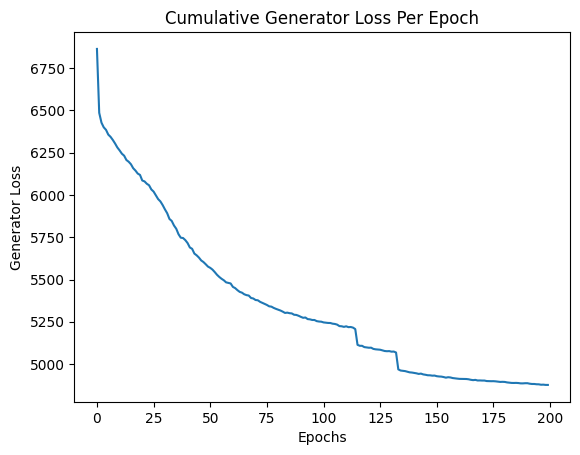

In [11]:
iterations = np.arange(0,200)
g_loss = np.array(g_loss)

plt.figure()
plt.plot()

plt.title("Cumulative Generator Loss Per Epoch") 
plt.xlabel("Epochs") 
plt.ylabel("Generator Loss") 
plt.plot(iterations, g_loss) 
plt.show()

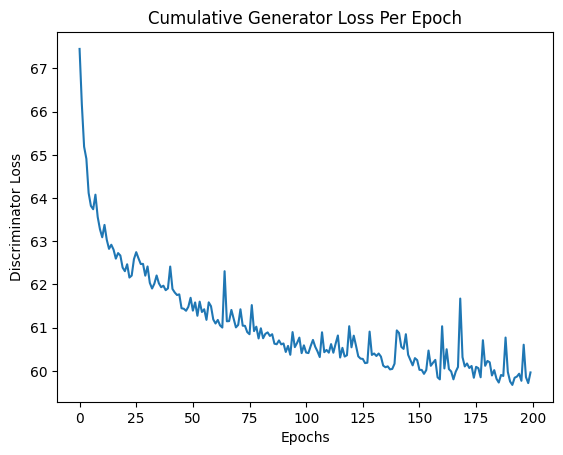

In [12]:
d_loss = np.array(d_loss)

plt.figure()
plt.plot()

plt.title("Cumulative Generator Loss Per Epoch") 
plt.xlabel("Epochs") 
plt.ylabel("Discriminator Loss") 
plt.plot(iterations, d_loss) 
plt.show()

In [14]:
torch.save(G.state_dict(), "pix2pix_generator.pt")

torch.save(D.state_dict(), "pix2pix_discriminator.pt")